### Loan Approval Prediction using Machine Learning
The object of this project is to develop a machine learning model that accurately predicts whether a loan application will be approved based on the applicant's personal and financial information.<br>
This Project aims to:
* Analyze historical loan data to identify key factors affecting approval.
* Perform data preprocessing and exploratory analysis.
* Build and evaluate Predictive models using machine leanring algorithms.
* Provide actionable insights to financial institutions to improve decision-making and reduce risk.

In [13]:
# import necessary libraries
import pandas as pd
import numpy as np

#Data visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and encoding
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score

sns.set(style = "whitegrid")

import warnings
warnings.filterwarnings("ignore")

#### Data Overview

In [3]:
# Load the dataset
df = pd.read_csv("../data/raw/loandataset.csv")

df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
print(f'The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.')

df.info()

#Check for missing values
print("\nMissing values per columns")
print(df.isnull().sum())

# basicc statistical summary 
df.describe()

The dataset contains 614 rows and 13 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB

Missing values per columns
Loan_ID               0
Gender        

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


#### EDA(Exploratory Data Analysis)

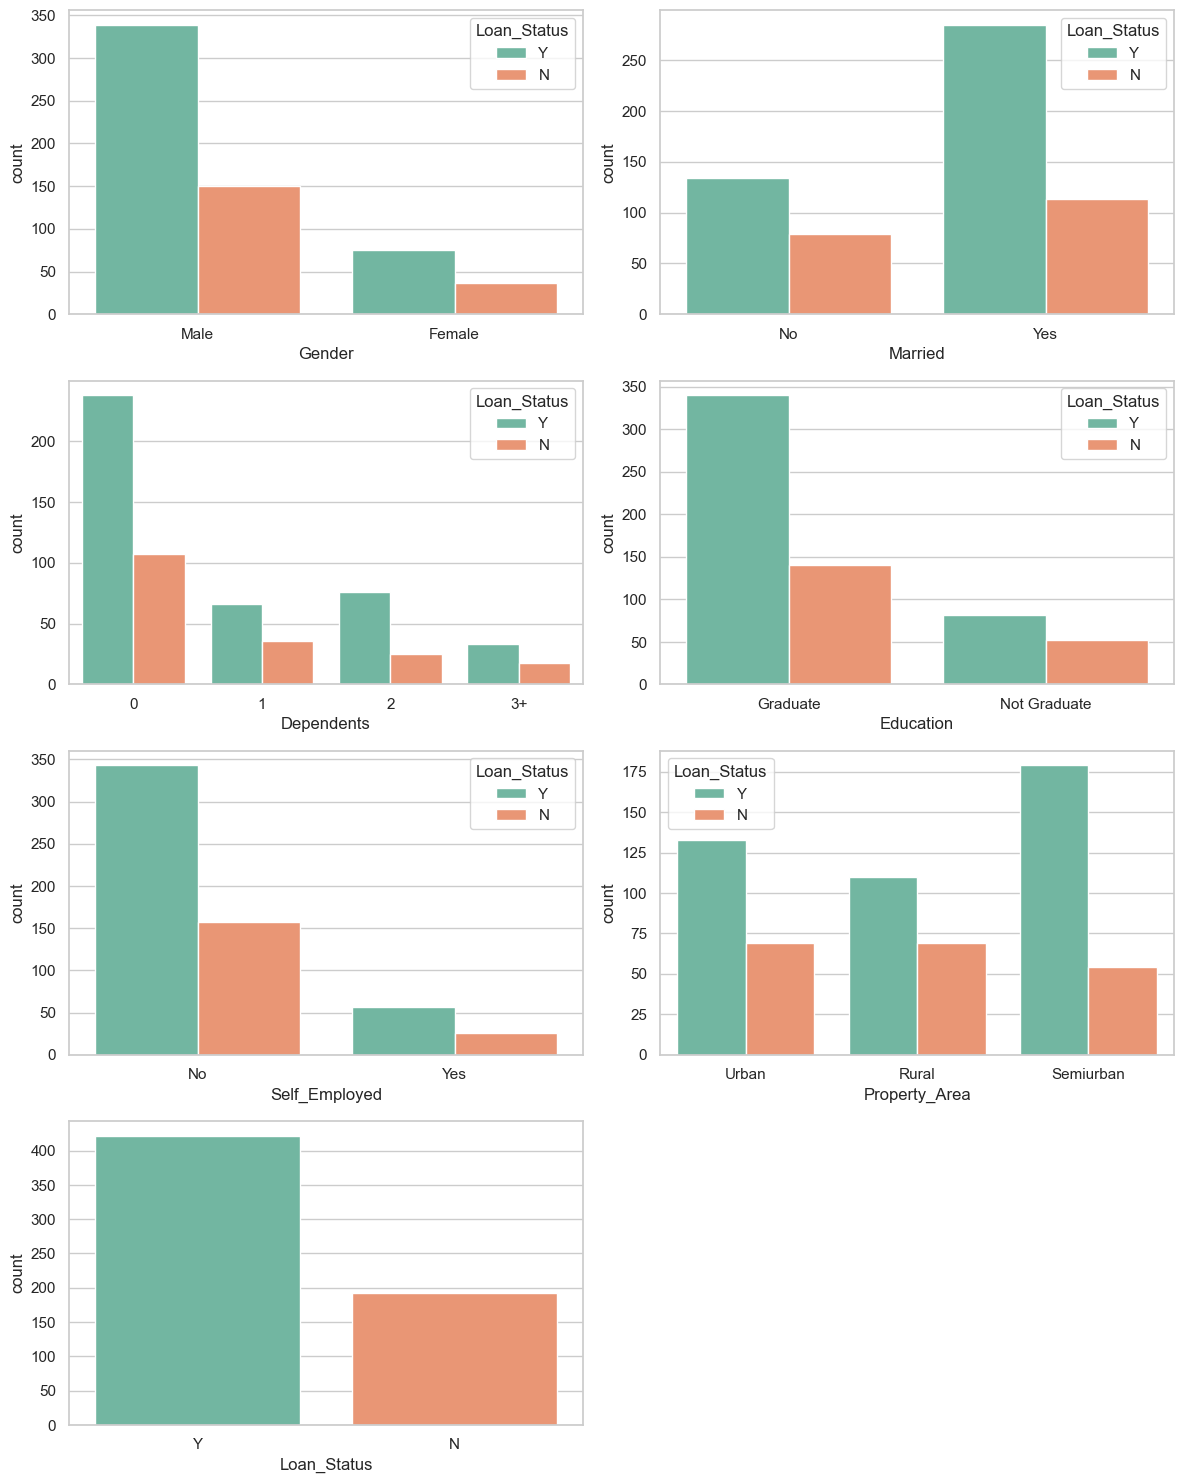

In [5]:
# EDA for the dataset 
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols[1:]

fig, axes = plt.subplots(4, 2, figsize=(12,15))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=df,ax =axes[i], palette='Set2', hue='Loan_Status')
    plt.title(f"Categorical Distribution of {col}")
fig.delaxes(axes[7])
plt.tight_layout()
plt.show()

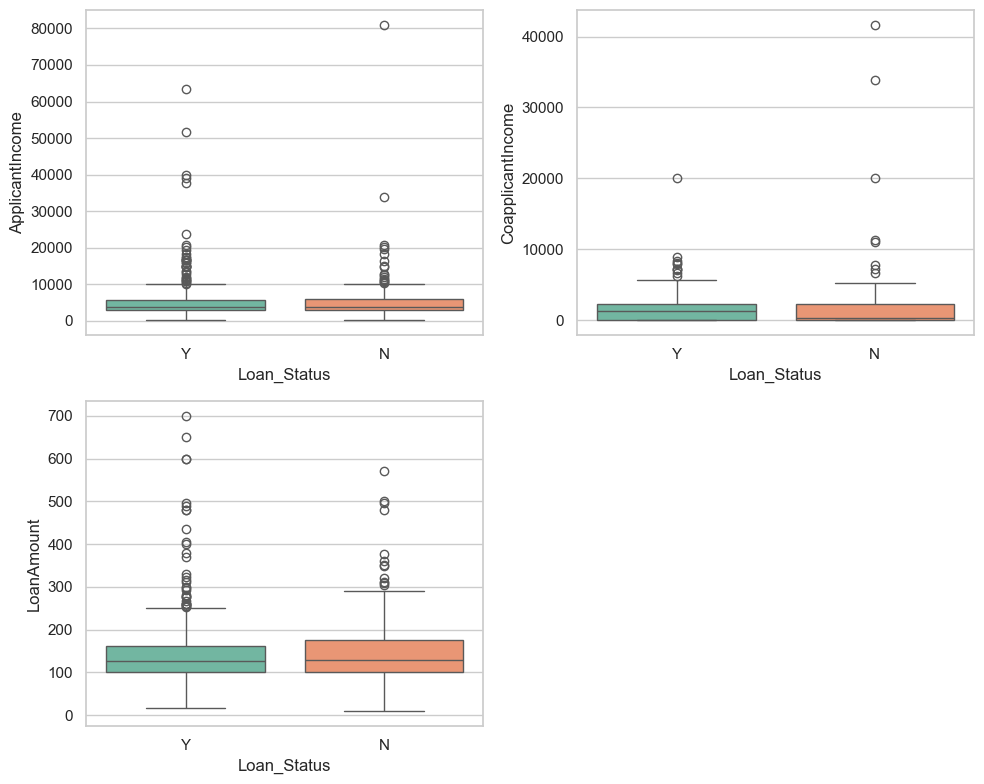

In [6]:
# EDA on numerical columns
numerical_cols = ['ApplicantIncome','CoapplicantIncome','LoanAmount']
fig, axes = plt.subplots(2,2, figsize=(10,8))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(y=col, data = df, x='Loan_Status', ax =axes[i], palette='Set2')
    plt.subplots_adjust(hspace=1)

plt.delaxes(axes[3])
plt.tight_layout()
plt.show()

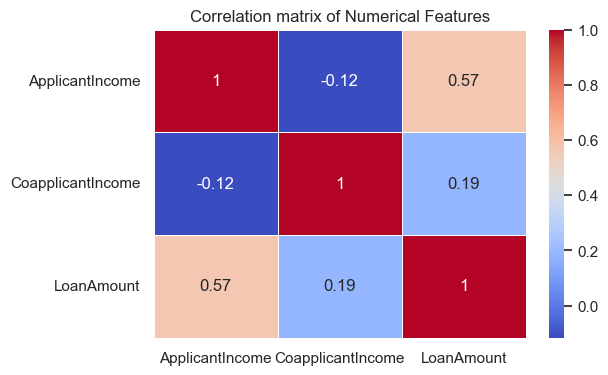

In [7]:
# Correlation matrix for numerical variables 
plt.figure(figsize=(6,4))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', linewidths = 0.4)
plt.title("Correlation matrix of Numerical Features")
plt.show()

### Feature Selection and engineering

### Plots above convey following things about the dataset:
* Loan Approval Status: About 2/3rd of applicants have been granted loan.
* Martial Status: 2/3 rd of population in the dataset is Married; Married applicants are more likely to be granted loans.
* Education: About 5/6th of the population is Graduate and graduates have higher propotion of loan approval.
* Employment: 5/6th of the population is not self employed.
* Employment: 5/6th of population is not self employed.
* Property Area: More applicants from Semi-Urban and also likely to be grannted loans.
* Applicant with credit history are far more likely to be accepted.
* Loan Amount Term: Majority of the loans taken are for 360 Months(30 years.)

#### Handling missing values
* As your dataset is small can't drop dataset
* so we fill the missing values with the higher frequency value occur in that column. It will be some bias but I think this method is best for our project for now.


In [8]:
#Handle missing values 
train_data = df.copy()
train_data['Gender'].fillna(train_data['Gender'].value_counts().idxmax(), inplace = True)
train_data['Married'].fillna(train_data['Married'].value_counts().idxmax(), inplace = True)
train_data['Dependents'].fillna(train_data['Dependents'].value_counts().idxmax(), inplace= True)
train_data['Self_Employed'].fillna(train_data['Self_Employed'].value_counts().idxmax(), inplace = True)
train_data['LoanAmount'].fillna(train_data['LoanAmount'].mean(skipna=True), inplace=True)
train_data['Loan_Amount_Term'].fillna(train_data['Loan_Amount_Term'].value_counts().idxmax(), inplace=True)
train_data['Credit_History'].fillna(train_data['Credit_History'].value_counts().idxmax(), inplace = True)

#### Encoding categorical columns

In [9]:
#Label Encoding
train_data['Gender'] = train_data['Gender'].replace({"Female": 0, "Male":1})
train_data['Married'] = train_data['Married'].replace({"No": 0, "Yes":1})
train_data['Dependents'] = train_data['Dependents'].replace({'0':0, '1':1, '2': 2, '3+':3})
train_data['Education'] = train_data['Education'].replace({"Not Graduate":0, "Graduate":1})
train_data['Self_Employed'] = train_data['Self_Employed'].replace({"No":0, "Yes":1})
train_data['Property_Area'] = train_data['Property_Area'].replace({'Semiurban': 0, 'Urban':1, 'Rural':2})
train_data['Loan_Status'] = train_data['Loan_Status'].replace({'Y':1, 'N':0})

In [10]:
# There is no use for loanID so gonna drop it
train_data = train_data.drop(columns=['Loan_ID'], axis=1)

In [11]:
# Split Dataset into train and test data
X = train_data.drop(columns=['Loan_Status'])
y = train_data['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

In [14]:
# Model Training 
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "XGBoost": XGBClassifier(random_state=42)
}


results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f'{name} - Accuracy: {acc:.4f}')
    print('Preicison: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1 Score: ', f1_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    results[name] = acc
    

Random Forest - Accuracy: 0.8211
Preicison:  0.8461538461538461
Recall:  0.9058823529411765
F1 Score:  0.875
              precision    recall  f1-score   support

           0       0.75      0.63      0.69        38
           1       0.85      0.91      0.88        85

    accuracy                           0.82       123
   macro avg       0.80      0.77      0.78       123
weighted avg       0.82      0.82      0.82       123

Decision Tree - Accuracy: 0.7398
Preicison:  0.8354430379746836
Recall:  0.7764705882352941
F1 Score:  0.8048780487804879
              precision    recall  f1-score   support

           0       0.57      0.66      0.61        38
           1       0.84      0.78      0.80        85

    accuracy                           0.74       123
   macro avg       0.70      0.72      0.71       123
weighted avg       0.75      0.74      0.74       123

Logistic Regression - Accuracy: 0.8537
Preicison:  0.8383838383838383
Recall:  0.9764705882352941
F1 Score:  0.9021

In [18]:
# Model evaluation on training dataset for high accuracy model
leg = LogisticRegression()
leg.fit(X_train, y_train)

y_pred = leg.predict(X_train)

print('Accuracy for logistic regression: ', accuracy_score(y_train, y_pred))

Accuracy for logistic regression:  0.8004073319755601


In [20]:
# for Random Forest Classifier Model

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_train)
print('Accuracy for Random forest Classifier: ', accuracy_score(y_train, y_pred))

Accuracy for Random forest Classifier:  1.0


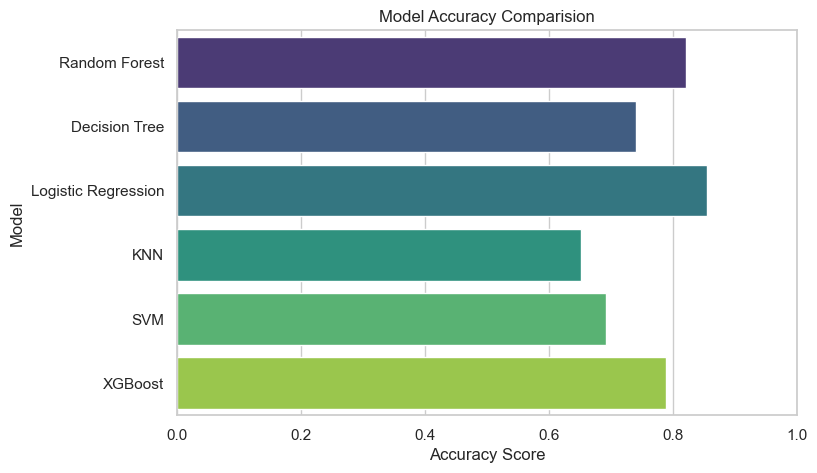

In [12]:
model_name = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(8,5))
sns.barplot(x = accuracies, y = model_name, palette='viridis')
plt.title('Model Accuracy Comparision')
plt.xlabel('Accuracy Score')
plt.ylabel('Model')
plt.xlim(0,1)
plt.show()

### Model Selection

After training and evaluating multiple machine learning models—including Logistic Regression, Decision Tree, Random Forest, and XGBoost—we selected the Random Forest and Logistic Regression model based on a balanced assessment of accuracy, precision, recall, F1-score, and cross-validation performance.

While several models showed similar accuracy levels, our final choice Linear Regression offered the best combination of:
- **Consistent performance** across training and testing datasets (minimal overfitting).
- **High F1-score**, indicating a good balance between precision and recall.
- **Interpretability** and feature importance analysis (in case of tree-based models).
- **Scalability and robustness** when applied to real-world, unseen data.


In [13]:
# Hyper parameter tuning for the best model

param_grid = {
    'n_estimators': [100,200,300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':[1,2,4]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, n_jobs = -1, scoring = 'accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [14]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Best Parameters: ", grid_search.best_params_)
print("Accuracy after tuning: ", accuracy_score(y_test, y_pred))
print("Classification Report : \n", classification_report(y_test, y_pred))

Best Parameters:  {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy after tuning:  0.8536585365853658
Classification Report : 
               precision    recall  f1-score   support

           0       0.92      0.58      0.71        38
           1       0.84      0.98      0.90        85

    accuracy                           0.85       123
   macro avg       0.88      0.78      0.81       123
weighted avg       0.86      0.85      0.84       123



In [21]:
y_pred = best_model.predict(X_train)

print('Accuracy score :', accuracy_score(y_train, y_pred))

Accuracy score : 0.824847250509165


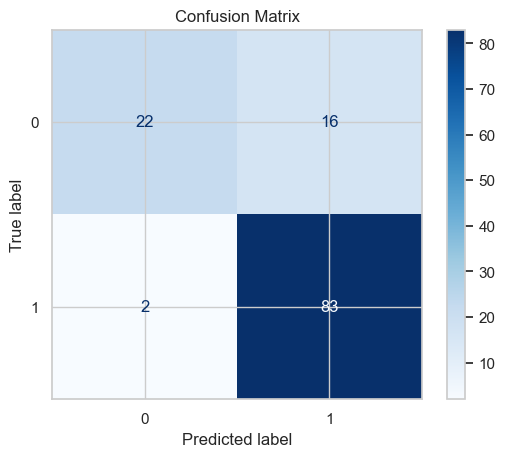

In [17]:
#Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display it visually
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=[0,1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [15]:
# Feature Importance
importances = best_model.feature_importances_
feature_names = X.columns

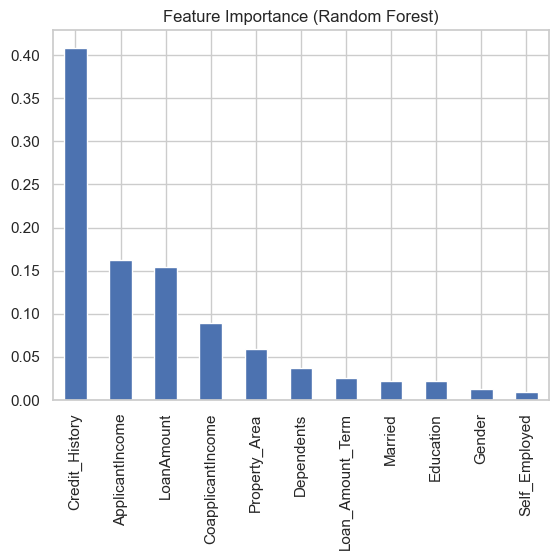

In [16]:
feat_imp = pd.Series(importances, index = feature_names).sort_values(ascending = False)
feat_imp.plot(kind='bar')
plt.title("Feature Importance (Random Forest)")
plt.show()

#### Feature Importance Analysis

After training the final model, we extracted and visualized the feature importances to identify the key drivers behind loan approval predictions.

#### Key Observations:
- **Credit_History** emerged as the most influential feature, significantly affecting the likelihood of loan approval. Applicants with a solid credit history were far more likely to be approved.
- **ApplicantIncome** and **LoanAmount** played crucial roles, indicating financial capacity is a major consideration.
- Features like **Loan_amount_term** and **Education** had relatively lower importance but still contributed to the model's decision-making process.



### Project Conclusion

In this project, we successfully developed a predictive model to estimate the likelihood of loan approval based on applicant financial and demographic information. The dataset was thoroughly analyzed through exploratory data analysis (EDA), revealing key patterns such as the strong influence of credit history and income levels on approval decisions.

We built and compared several machine learning models including Logistic Regression, Decision Tree, Random Forest, and XGBoost. After evaluating each model using accuracy, precision, recall, F1-score, and cross-validation, we selected RandomForestClassifier as the best performer due to its balance of predictive power and generalization.

This project demonstrates how machine learning can assist financial institutions in automating loan decisions, reducing risk, and improving transparency. With further tuning and integration, this model could serve as the foundation for a scalable, real-world credit assessment system.
